### 이상치 요약

- SalePrice의 데이터에는 80개의 변수가 존재하여 모든 변수의 이상치를 파악하기 어려웠다. 따라서 PCA 방법을 고려하여 간단하게 살펴보기로 결정하였다.

- PCA 방법으로 탐지된 이상치는 523, 691, 1182, 1298 이다.

- 하지만, 4 개 데이터 모두 OverallQual 값이 10이므로 이상치가 아니라 특정 변수에 의해서 SalePrice의 값이 상승했을 가능성이 크다고 판단하였다.

- 따라서 이상치를 제거하지 않고 모델링을 진행하기로 했으며, 잔차를 통해 이상치 전처리에 대해 다시 고려하기로 판단하였다.

In [20]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

from matplotlib import rcParams

In [21]:
PATH = 'C:\\Users\\이찬영\\Desktop\\House_Price\\'
train = pd.read_csv(PATH + '\\complete_train.csv')
X_test = pd.read_csv(PATH + '\\complete_test.csv')

In [22]:
house_df = pd.concat([train, X_test], ignore_index= True, sort = False)
tr_idx = house_df['SalePrice'].notnull()

In [23]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [24]:
def outlier_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower = q1 - (iqr*2)
    upper = q3 + (iqr*2)
    return np.where((data > upper)|(data < lower))

In [25]:
house_df.drop('Id', axis = 1, inplace= True, errors = 'ignore')

### Outliers 확인
- 여러 변수들 중 GrLivArea, TotalBsmtSF 와 SalePrice의 관계를 살펴봤을 때 이상치가 있는 것으로 보인다.

    - 변수가 상당히 많아 데이터 간의 모든 관계를 파악하기 어렵기 때문에 PCA를 활용하여 이상치를 판별하기로 하였다.

    - 또한, PCA로 판별된 이상치는 유사한 변수들과 관련지어 제거 유무를 결정하기로 하였다.

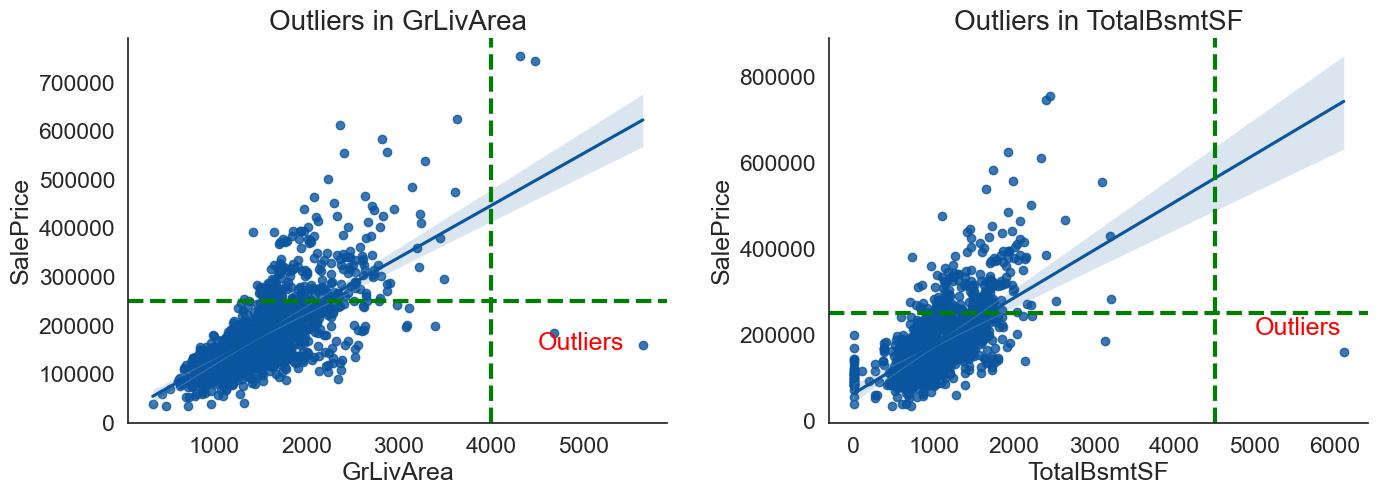

In [26]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("Blues_r")
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.3)
ax1 = sns.regplot(data=house_df, x='GrLivArea',y='SalePrice')
ax1.set_title('Outliers in GrLivArea',fontsize=20)
plt.axhline(y=250000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4000, color='Green', linestyle='--', linewidth=3)
plt.text(4500, 150000, 'Outliers',color='red')
plt.subplot(1,2,2)
ax2 = sns.regplot(data=house_df, x='TotalBsmtSF',y='SalePrice')
ax2.set_title('Outliers in TotalBsmtSF',fontsize=20)
plt.axhline(y=250000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4500, color='Green', linestyle='--', linewidth=3)
plt.text(5000, 200000, 'Outliers',color='red')
sns.despine()

### PCA 이상치 판별
- PCA로 이상치를 판별한 관측치는 523, 691, 1182, 1298 이다.

In [27]:
features = ['GrLivArea','LotFrontage', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']

In [28]:
house_copy = house_df[tr_idx].copy()
y_copy = house_copy.pop('SalePrice')
X_copy = house_copy.loc[:, features]

pca, X_pca, loadings = apply_pca(X_copy)

In [29]:
import plotly.express as px

fig = px.histogram(X_pca[['PC1','PC2']].melt(), color = 'variable',
                   marginal = 'box',
                   barmode = 'overlay',
                   histnorm = 'density')

fig.update_layout(
    title_font_color = 'white',
    legend_title_font_color = 'yellow',
    title = {
        'text' : "PCA Histogram",
        'x' : 0.5,
        'xanchor' : 'center',
        'yanchor' : 'top'},
    paper_bgcolor = 'black',
    plot_bgcolor = 'black',
    font_color = 'white',
)

In [30]:
pc1_outlier_idx = list(outlier_iqr(X_pca['PC1'])[0])

In [31]:
component = "PC1"

pc1_idx = X_pca[component].sort_values(ascending= False).index
df_temp_pc1 = house_df.loc[pc1_idx, ["SalePrice","Neighborhood", "SaleCondition"] + features]


df_temp_pc1.loc[pc1_outlier_idx, :].style.set_properties(**{'background-color': 'Grey',
                                                             'color': 'white',
                                                             'border-color': 'darkblack'})

,SalePrice,Neighborhood,SaleCondition,GrLivArea,LotFrontage,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GarageArea
523,184750.000000,Edwards,Partial,4676,130.000000,2007,2008,2260.000000,878.000000,3138.000000,884.000000
691,755000.000000,NoRidge,Normal,4316,104.000000,1994,1995,1455.000000,989.000000,2444.000000,832.000000
1182,745000.000000,NoRidge,Abnorml,4476,160.000000,1996,1996,2096.000000,300.000000,2396.000000,813.000000
1298,160000.000000,Edwards,Partial,5642,313.000000,2008,2008,5644.000000,466.000000,6110.000000,1418.000000


In [32]:
pc2_outlier_idx = list(outlier_iqr(X_pca['PC2'])[0])

In [33]:
component = "PC2"

pc2_idx = X_pca[component].sort_values(ascending=False).index
df_temp_pc2 = house_df.loc[pc2_idx, ['SalePrice','Neighborhood', 'SaleCondition'] + features]

df_temp_pc2.loc[pc2_outlier_idx,:].style.set_properties(**{'background-color':'Grey',
                                                            'color' : 'white',
                                                            'border-color':'darkblack'})

,SalePrice,Neighborhood,SaleCondition,GrLivArea,LotFrontage,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GarageArea
1298,160000.000000,Edwards,Partial,5642,313.000000,2008,2008,5644.000000,466.000000,6110.000000,1418.000000


In [34]:
outlier_list = list(set(pc1_outlier_idx + pc2_outlier_idx))

In [35]:
outlier_list

[1298, 523, 691, 1182]

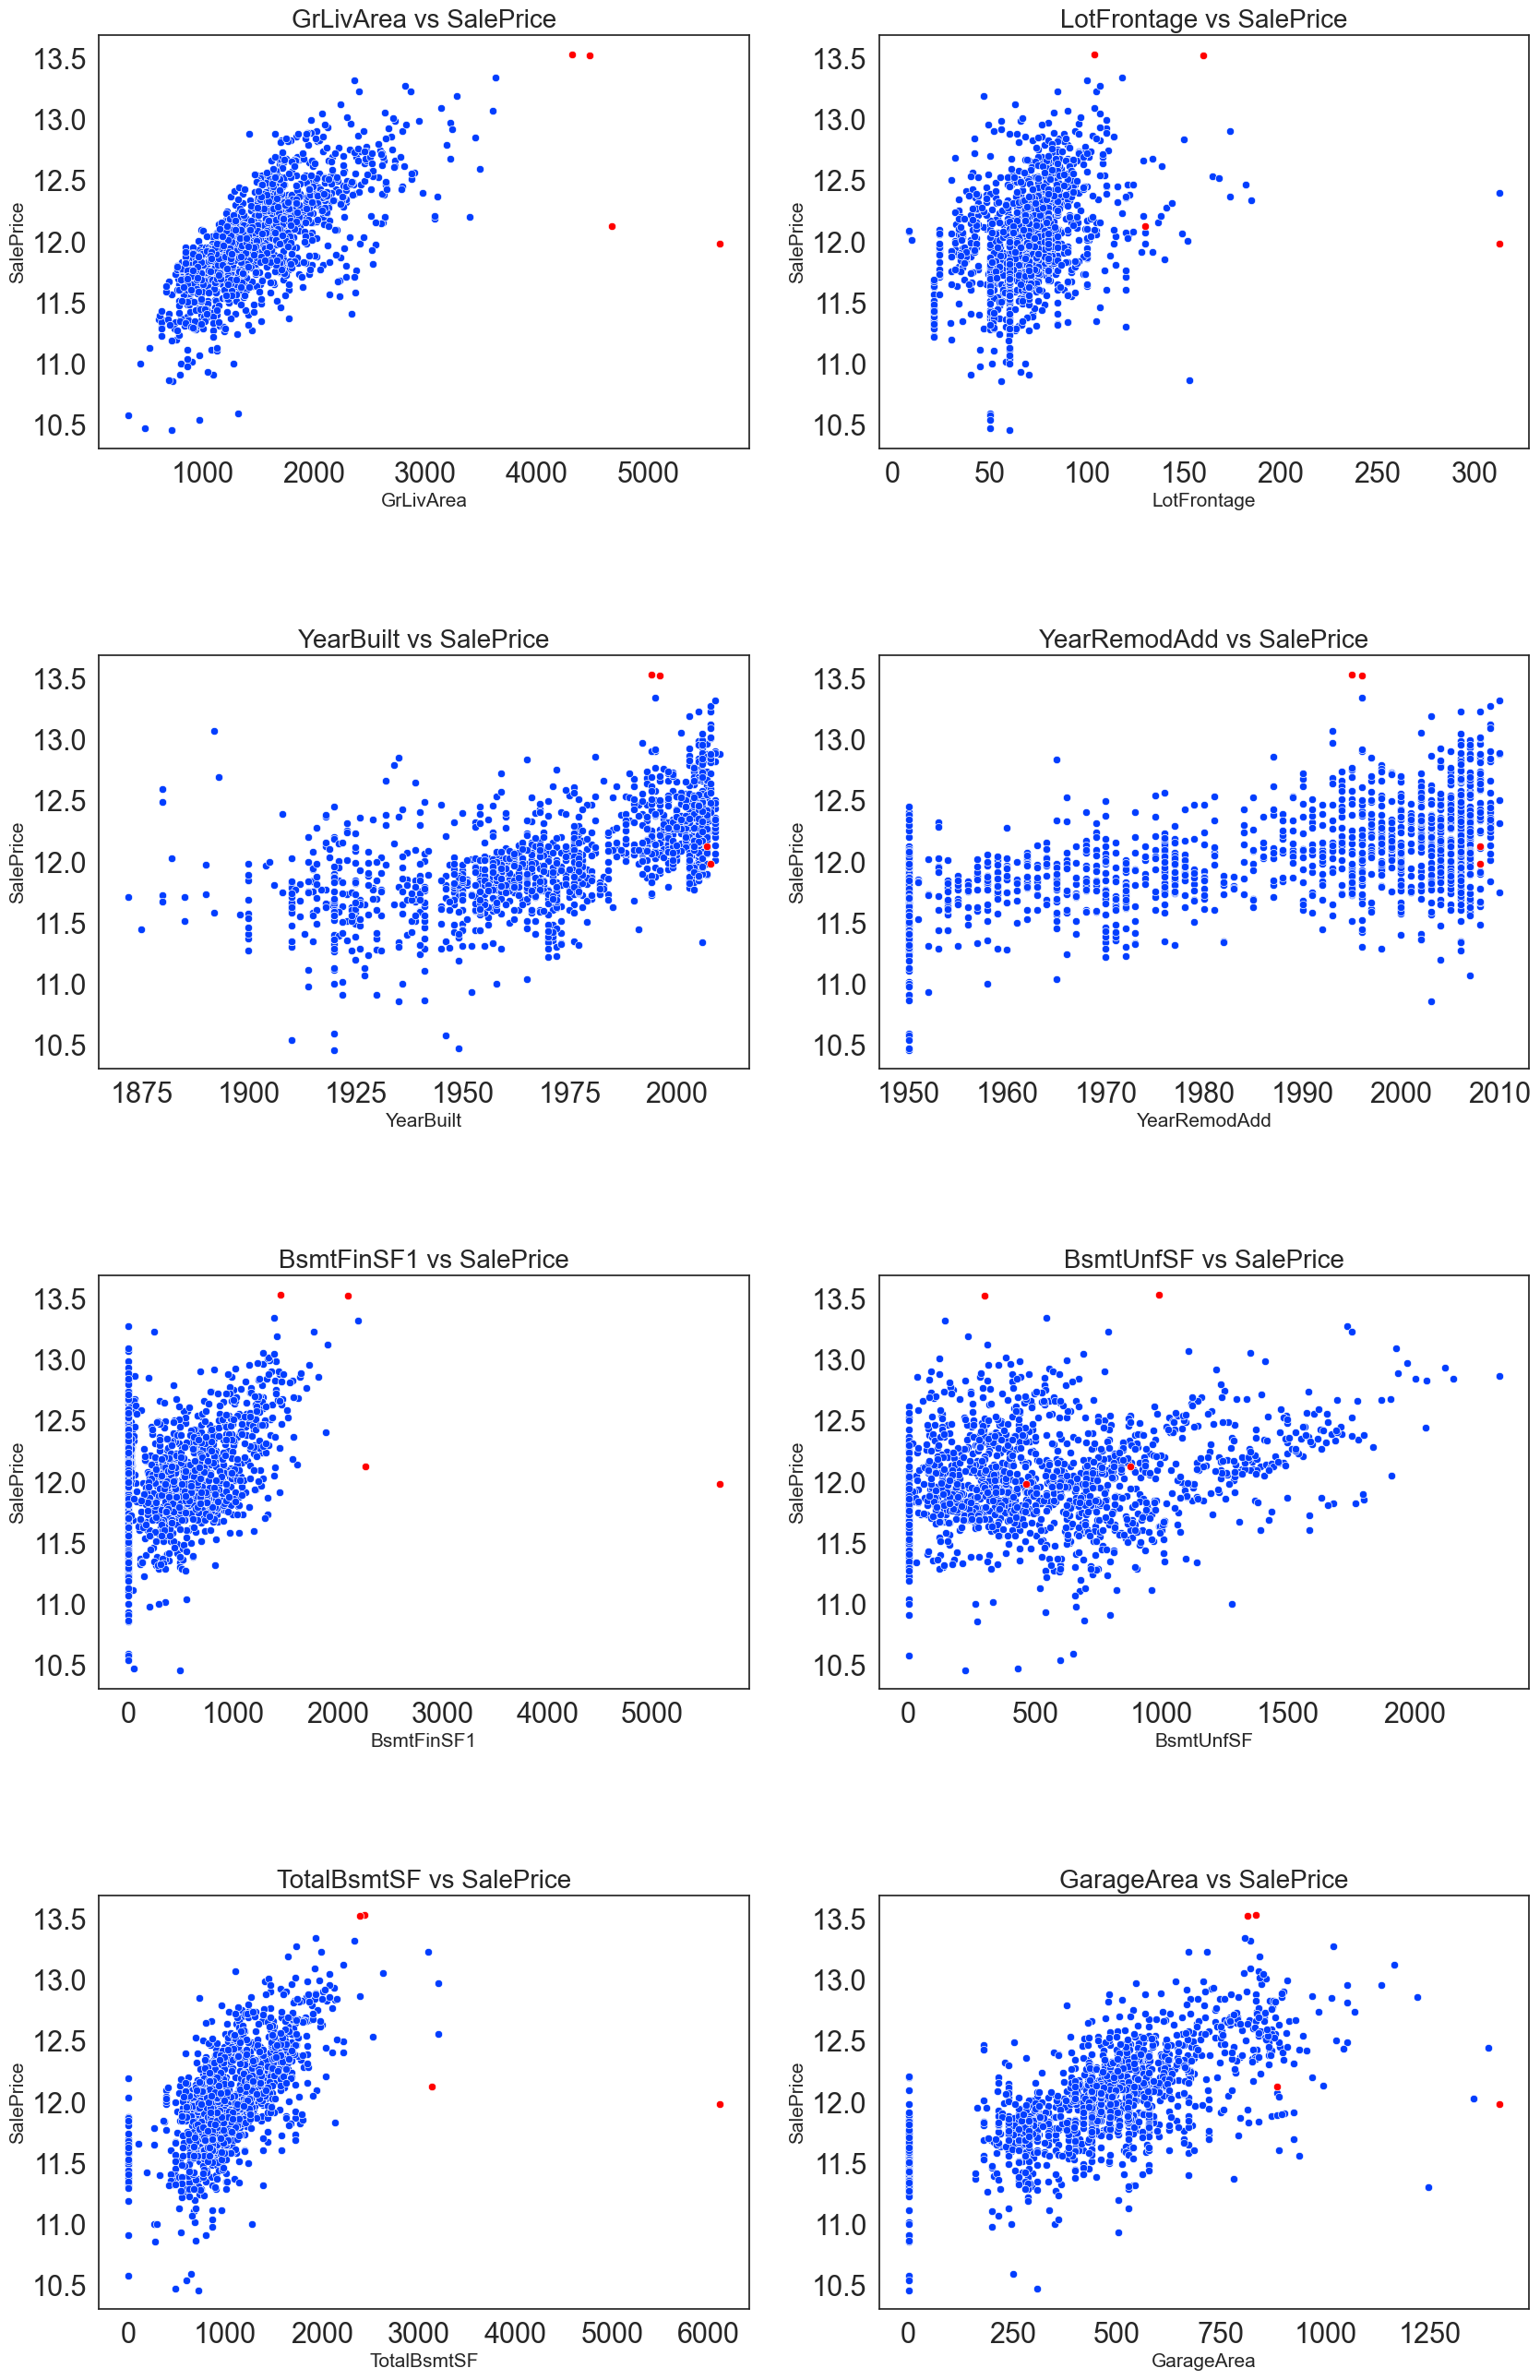

In [36]:
import math

sns.set(font_scale=2)
sns.set_style("white")
sns.set_palette("bright")

num_plots = len(features)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)

plt.figure(figsize=(20, num_rows * 8))  # Adjusted figsize
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(features, start=1):
    plt.subplot(num_rows, num_cols, i)
    sns.scatterplot(x = col, y = np.log1p(house_df.drop(index = outlier_list)['SalePrice']),data = house_df.drop(index = outlier_list))
    sns.scatterplot(x = col, y = np.log1p(house_df.loc[outlier_list,'SalePrice']),data = house_df.loc[outlier_list,:], color = 'red')
    plt.title(f'{col} vs SalePrice', fontsize=20)  # Added title
    plt.xlabel(col, fontsize=15)  # Added xlabel
    plt.ylabel('SalePrice', fontsize=15)  # Added ylabel

plt.show()

- outlier 관측치 (523, 691, 1182, 1298)

    - 4개 관측치 모두 OverallQual의 값이 10이므로 이상치가 아니라 특정 변수에 의해서 SalePrice의 값이 상승했을 가능성이 크다고 판단하였다.

    - 따라서 이상치를 제거하지 않고 모델링을 진행하기로 했으며, 잔차 분석을 통해 이상치 전처리에 대해 다시 고려하기로 하였다.

In [37]:
house_df.loc[outlier_list,['OverallQual', 'LotFrontage', 'LotArea', 'LandContour', 'LotConfig', 'Neighborhood', 'GrLivArea', 'SalePrice']]

,OverallQual,LotFrontage,LotArea,LandContour,LotConfig,Neighborhood,GrLivArea,SalePrice
1298,10,313.0,63887,Bnk,Corner,Edwards,5642,160000.0
523,10,130.0,40094,Bnk,Inside,Edwards,4676,184750.0
691,10,104.0,21535,Lvl,Corner,NoRidge,4316,755000.0
1182,10,160.0,15623,Lvl,Corner,NoRidge,4476,745000.0
